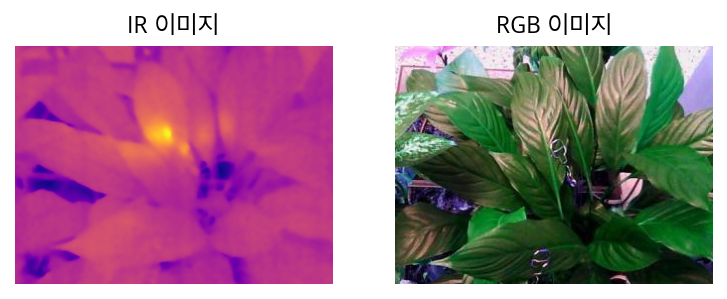

In [19]:
import common
import cv2
import matplotlib.pyplot as plt

WIDTH = 320
HEIGHT = 240

ir = common.load_ir_in_csv('./plant-ir/121.csv')
rgb = cv2.imread('./plant-rgb/FLIR0121- 사진.jpg')

fig, axs = plt.subplots(1, 2)
fig.dpi = 150
axs[0].imshow(ir, cmap='plasma')
axs[0].axis(False)
axs[0].set_title('IR 이미지')
axs[1].imshow(rgb)
axs[1].axis(False)
axs[1].set_title('RGB 이미지')
plt.show()

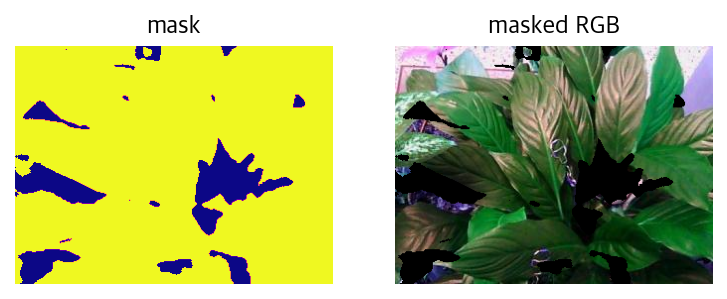

In [20]:
from jenkspy import jenks_breaks
import numpy as np

ir_breaks = jenks_breaks(ir.ravel(), nb_class=2)

mask = np.zeros(shape=(HEIGHT, WIDTH), dtype=np.uint8)
for row, col in np.ndindex(ir.shape):
    mask[row, col] = 0xFF if ir_breaks[1] < ir[row, col] else 0

fig, axs = plt.subplots(1, 2)
fig.dpi = 150
axs[0].imshow(mask, cmap='plasma')
axs[0].axis(False)
axs[0].set_title('mask')
axs[1].imshow(cv2.bitwise_and(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), rgb))
axs[1].axis(False)
axs[1].set_title('masked RGB')
plt.show()


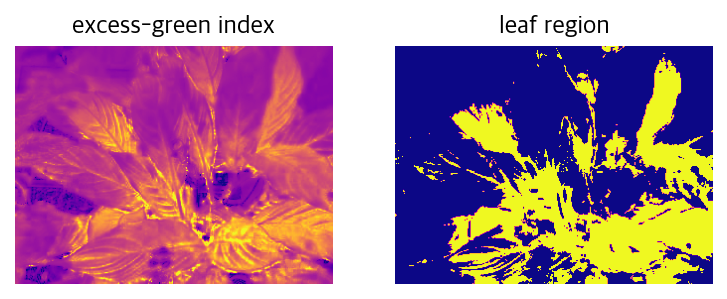

In [22]:
# compute excess-green
exg = np.zeros(shape=(HEIGHT, WIDTH))
for row, col, _channel in np.ndindex(rgb.shape):
    # TODO: handle exception when dividing by zero
    if rgb[row][col].sum() == 0:
        b, g, r = 0, 0, 0
    else:
        b, g, r = rgb[row][col] / rgb[row][col].sum()
    exg[row][col] = 2 * g - r - b


breaks = jenks_breaks(exg.ravel(), nb_class=2)

leaf = np.zeros(shape=(HEIGHT, WIDTH), dtype=np.uint8)
for row, col in np.ndindex(leaf.shape):
    leaf[row, col] = 0xFF if breaks[1] <= exg[row, col] else 0

fig, axs = plt.subplots(1, 2)
fig.dpi = 150
axs[0].imshow(exg, cmap='plasma')
axs[0].axis(False)
axs[0].set_title('excess-green index')
axs[1].imshow(leaf, cmap="plasma")
axs[1].axis(False)
axs[1].set_title('leaf region')
plt.show()


In [ ]:
max_temperature = np.max(ir[mask == 0xFF])
min_temperature = np.min(ir[mask == 0xFF])

print('온도 최대값:', max_temperature)
print('온도 최소값:', min_temperature)
print('온도 평균값:', common.get_average_tempeature(ir, mask))

온도 최대값: 28.469
온도 최소값: 25.324
온도 평균값: 25.80181457479012
